# TalkingData: Fraudulent Click Prediction






## Understanding the Business Problem

<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">the problem on Kaggle here.</a>.

## Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```attributed_time```: if user download the app for after clicking an ad, this is the time of the app download
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [0]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [0]:
# reading training data

# specify column dtypes to save memory (by default pandas reads some columns as floats)
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

# read training data
train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)


In [3]:
len(train_sample.index)

100000

In [4]:
print(train_sample.memory_usage())

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64


In [5]:
 train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


### Exploring the Data - Univariate Analysis


In [6]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null uint16
app              100000 non-null uint16
device           100000 non-null uint16
os               100000 non-null uint16
channel          100000 non-null uint16
click_time       100000 non-null object
is_attributed    100000 non-null uint8
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


In [7]:
# Basic exploratory analysis

#number of unique values in each column
def fraction_unique(X):
  return  len(train_sample[X].unique())

num_unique_vals={x: fraction_unique(x) for x in train_sample.columns}
num_unique_vals

{'app': 161,
 'channel': 161,
 'click_time': 80350,
 'device': 100,
 'ip': 28470,
 'is_attributed': 2,
 'os': 130}

In [8]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

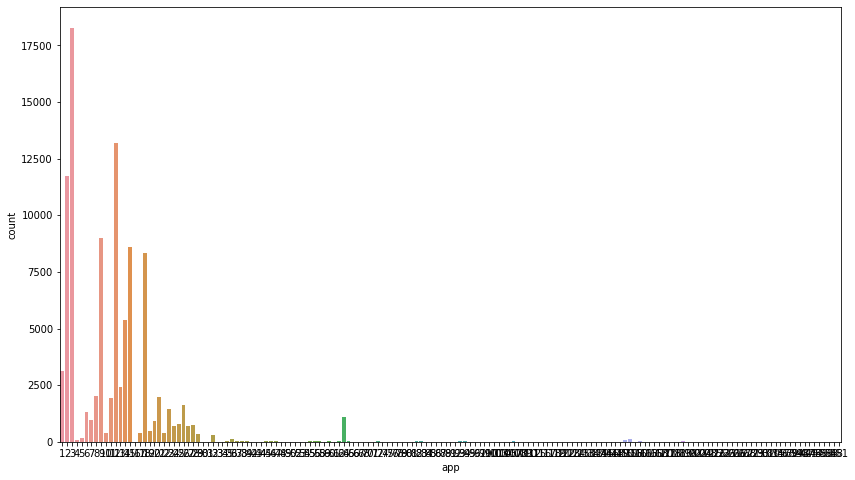

In [9]:
# distribution of app
# some 'apps' have a disproportionate high number of clicks(>15K)
plt.figure(figsize=(14,8))
sns.countplot(x='app',data=train_sample)

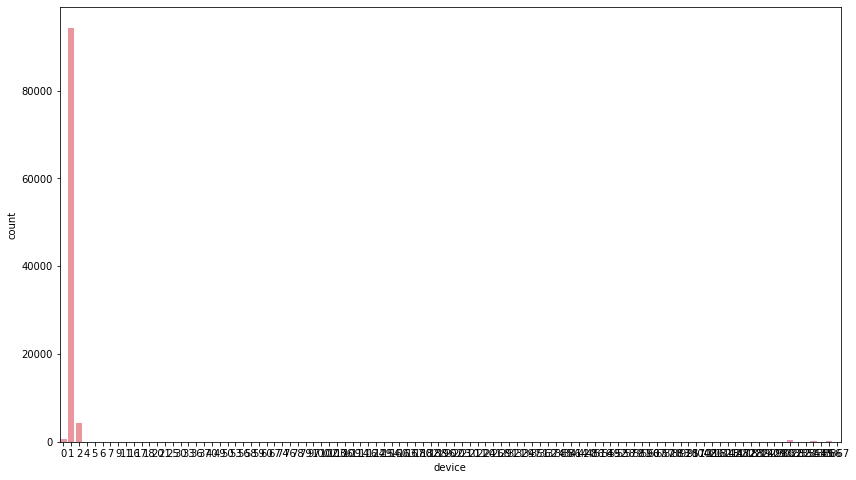

In [10]:
# distribution of device
# this is expected because a few popular devices are used heavily
plt.figure(figsize=(14,8))
sns.countplot(x='device',data=train_sample)

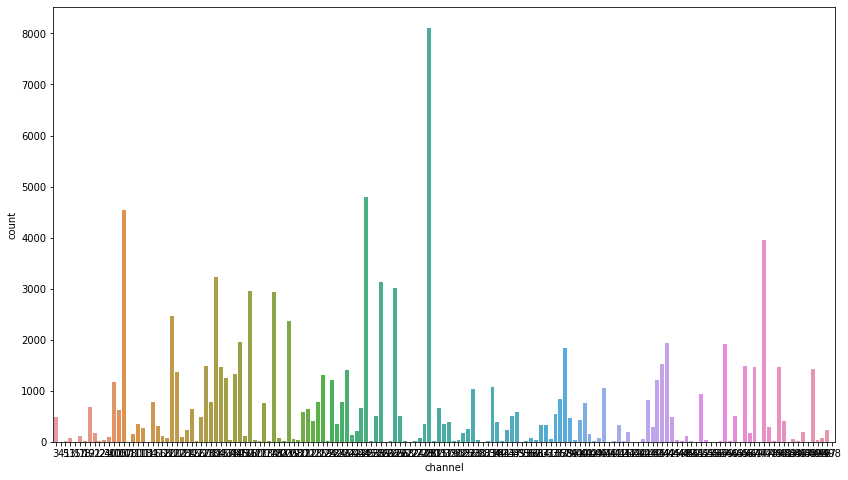

In [11]:
# channels: various channels gets clicks in comparable quantities
plt.figure(figsize=(14,8))
sns.countplot(x="channel",data=train_sample)

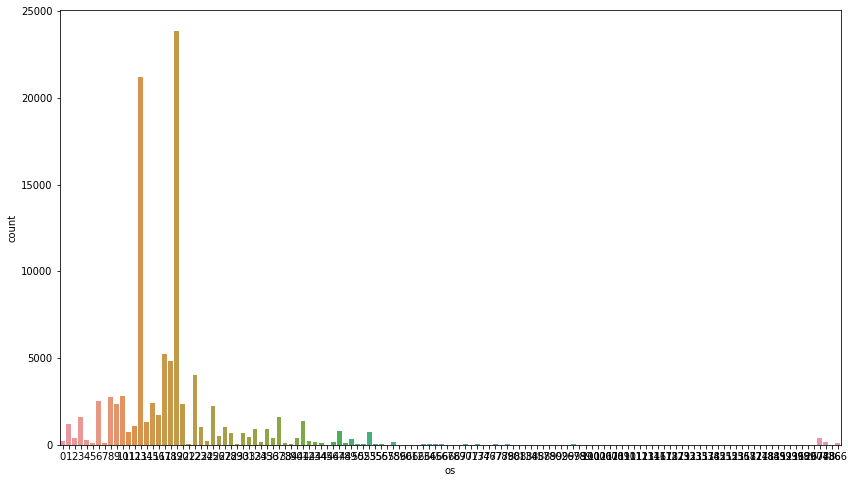

In [12]:
# os : few os are used too much
plt.figure(figsize=(14,8))
sns.countplot(x="os",data=train_sample)

In [13]:
# target variable distribution
100*(train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

Only **about 0.2% of the clicks are fraudulen**.

#### Exploring the Data- Segmented Univariate Analysis

In [14]:
# plot the average of 'is_attributed', or 'download rate'
# with app (clearly this is non-readable)
app_target = train_sample.groupby('app').is_attributed.agg(['mean', 'count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [15]:
frequent_apps=train_sample.groupby('app').size().reset_index(name='count')
frequent_apps=frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps=frequent_apps.merge(train_sample,on='app',how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


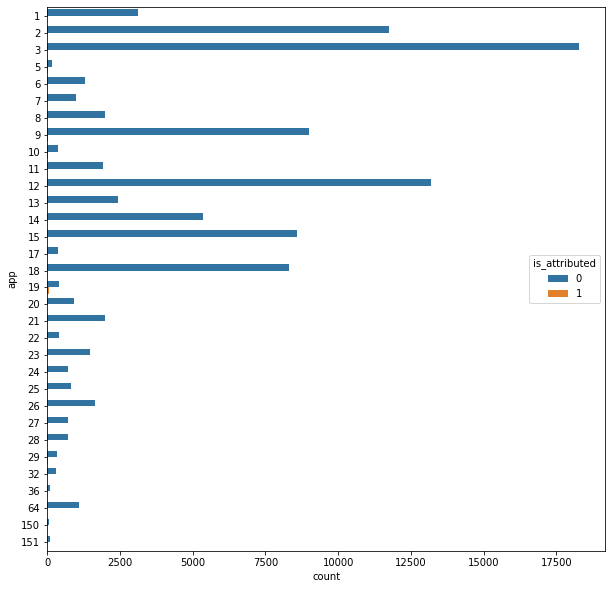

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(y='app',hue="is_attributed",data=frequent_apps)

## Feature Engineering

Let's now derive some new features from the existing ones. There are a number of features one can extract from ```click_time``` itself, and by grouping combinations of IP with other features.

#### Datetime Based Features

In [0]:
# Creating datetime variables
# takes in a df, adds date/time based columns to it, and returns the modified df
def timeFeatures(df):
    # Derive new features using the click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df["day_of_year"] = df["datetime"].dt.dayofyear
    df["month"] = df["datetime"].dt.month
    df["hour"] = df["datetime"].dt.hour
    return df

In [18]:
# creating new datetime variables and dropping the old ones
train_sample = timeFeatures(train_sample)
train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [19]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
ip               100000 non-null uint16
app              100000 non-null uint16
device           100000 non-null uint16
os               100000 non-null uint16
channel          100000 non-null uint16
is_attributed    100000 non-null uint8
day_of_week      100000 non-null int64
day_of_year      100000 non-null int64
month            100000 non-null int64
hour             100000 non-null int64
dtypes: int64(4), uint16(5), uint8(1)
memory usage: 4.1 MB


In [0]:
int_vars=['app','device','os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

In [21]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

#### IP Grouping Based features

Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

In [22]:
# number of clicks by count of IP address
# note that we are explicitly asking pandas to re-encode the aggregated features 
# as 'int16' to save memory
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


In [0]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [0]:
train_sample = grouped_features(train_sample)

In [25]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [26]:
import gc
gc.collect()

26

### Modelling

Let's now build models to predict the variable ```is_attributed``` (downloaded). We'll try the several variants of boosting (adaboost, gradient boosting and XGBoost), tune the hyperparameters in each model and choose the one which gives the best performance.

In the original Kaggle competition, the metric for model evaluation is **area under the ROC curve**.

In [27]:
# create x and y train
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [28]:
# check the average download rates in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


## Adaboost

In [0]:
# base estimator
tree=DecisionTreeClassifier(max_depth=2)

#adaboost with tree as base estimator
abc=AdaBoostClassifier(base_estimator=tree,
                      n_estimators=600,
                      learning_rate=1.5,
                      algorithm="SAMME")

In [30]:
# fit
abc.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [31]:
#predictions
pred=abc.predict_proba(X_test)
pred[:10]

array([[0.5259697 , 0.4740303 ],
       [0.52720083, 0.47279917],
       [0.533081  , 0.466919  ],
       [0.52194781, 0.47805219],
       [0.51032691, 0.48967309],
       [0.52721323, 0.47278677],
       [0.5183883 , 0.4816117 ],
       [0.52170927, 0.47829073],
       [0.52412251, 0.47587749],
       [0.51552875, 0.48447125]])

In [32]:
# mtrics AUC
metrics.roc_auc_score(y_test, pred[:,1])

0.928385534118433

## Adaboost hyperparameter Tuning

In [0]:
# parameter grid
param_grid = {"base_estimator__max_depth" : [2, 5],
              "n_estimators": [200, 400, 600]
             }

In [0]:
# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6, we'll discuss learning_rate below
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [0]:
# run grid search
folds = 3
grid_search_ABC = GridSearchCV(ABC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [36]:
# fit 
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                                mi

In [37]:
cv_results=pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,9.697552,0.079741,0.304205,0.003059,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,6.111043e-04
1,19.408338,0.205433,0.586873,0.006756,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,6.179779e-04
2,29.033770,0.127067,0.868224,0.007076,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,2.530744e-04
3,20.886889,0.193437,0.378716,0.001470,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.902358,0.943094,0.937463,0.927638,0.018023,4,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,42.283430,0.308036,0.748982,0.006909,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.900795,0.931125,0.945019,0.925646,0.018465,5,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,63.452610,0.791986,1.107653,0.001097,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.882437,0.925900,0.937725,0.915354,0.023771,6,1.000000,1.000000,1.000000,1.000000,6.409876e-17


In [38]:
#plotting AUC with hyperparameter combination

plt.figure(figsize=(16,6))
for depth in enumerate(param_grid['base_estimator_max_depth']):
  
  #subplot 1/n
  plt.subplot(1,3,2)
  depth_df = cv_results[cv_results['param_base_estimator_max_depth']==depth]

  plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"])
  plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"])
  plt.xlabel('n_estimators')
  plt.ylabel('AUC')
  plt.title("max_depth={0}".format(depth))
  plt.ylim([0.60, 1])
  plt.legend(['test score', 'train score'], loc='upper left')
  plt.xscale('log')

KeyError: ignored

<Figure size 1152x432 with 0 Axes>

### Gradient Boosting Classifier

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - ```learning_rate``` (shrinkage) and ```subsample```. 

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between ```learning_rate``` and ```n_estimators``` - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting ```subsample``` to less than 1), we can have the individual models built on random subsamples of size ```subsample```. That way, each tree will be trained on different subsets and reduce the model's variance.

In [0]:
#parameter grid
param_grid={"learning_rate":[0.2,0.6,0.9],
           "subsample":[0.3,0.6,0.9]}

In [0]:
# adaboost with tree as base estimator
GBC=GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [0]:
#running grid search
folds=3
grid_search_GBC=GridSearchCV(GBC,
                            cv=folds,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            return_train_score=True,
                            verbose=1)

In [43]:
grid_search_GBC.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=2,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
                                                  presort=

In [45]:
cv_results=pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.012208,0.042615,0.040576,0.001229,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.455238,0.825392,0.799772,0.693466,0.168779,4,0.563767,0.873153,0.857625,0.764848,0.142327
1,6.118779,0.043162,0.040450,0.001058,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.906015,0.943355,0.790963,0.880112,0.064854,1,0.905959,0.913540,0.810068,0.876522,0.047092
2,5.334292,0.101674,0.042598,0.001639,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.793566,0.885267,0.932241,0.870357,0.057587,2,0.753398,0.927485,0.886840,0.855908,0.074360
3,4.965872,0.020857,0.039923,0.001088,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.601543,0.687398,0.641164,0.643368,0.035085,5,0.537118,0.738693,0.612332,0.629381,0.083171
4,6.064020,0.075476,0.038816,0.000823,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.790351,0.520513,0.816287,0.709049,0.133736,3,0.764350,0.581366,0.841490,0.729068,0.109086


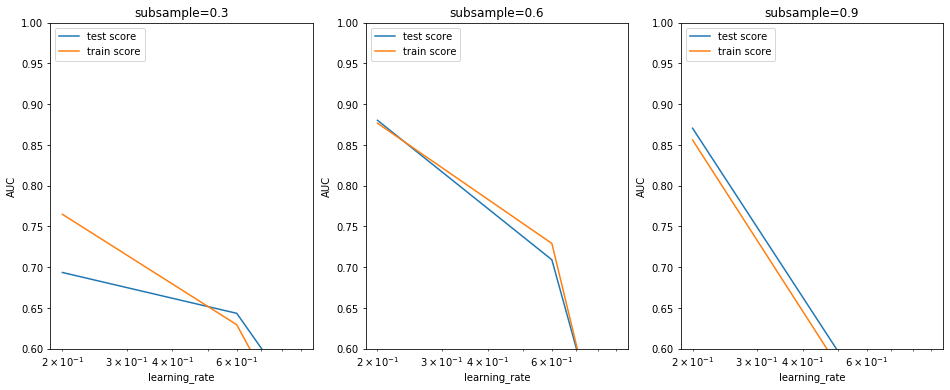

In [46]:
# # plotting
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

## XGBoost

In [47]:
model=XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
y_pred=model.predict_proba(X_test)
y_pred[:10]

array([[9.9987620e-01, 1.2377757e-04],
       [9.9980235e-01, 1.9764129e-04],
       [9.9981219e-01, 1.8779545e-04],
       [9.9935341e-01, 6.4659910e-04],
       [9.9839455e-01, 1.6054598e-03],
       [9.9982888e-01, 1.7113073e-04],
       [9.9954700e-01, 4.5297624e-04],
       [9.9944913e-01, 5.5086729e-04],
       [9.9976951e-01, 2.3048650e-04],
       [9.9696469e-01, 3.0353032e-03]], dtype=float32)

In [51]:
roc=metrics.roc_auc_score(y_test,y_pred[:,1])
print("AUC: %0.2f%%" % (roc*100))

AUC: 94.85%


In [0]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      


In [53]:
model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_

In [54]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.974562,0.021567,0.131034,0.001618,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.914064,0.971373,0.962963,0.949467,0.025268,3,0.990450,0.984303,0.988183,0.987645,0.002538
1,5.529229,0.007631,0.127776,0.000909,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.926961,0.973582,0.961443,0.953995,0.019748,1,0.994016,0.986355,0.992693,0.991021,0.003343
2,4.925866,0.046013,0.127238,0.002910,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924236,0.975867,0.951012,0.950372,0.021083,2,0.992880,0.989807,0.993936,0.992208,0.001752
3,4.944206,0.022930,0.130203,0.002040,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.885865,0.957231,0.940434,0.927843,0.030465,6,0.997522,0.991143,0.993425,0.994030,0.002639
4,5.535833,0.031588,0.128227,0.001269,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.893749,0.967978,0.955700,0.939142,0.032487,5,0.999624,0.997823,0.998964,0.998804,0.000744
5,4.933936,0.029902,0.129138,0.001349,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.923785,0.975658,0.947313,0.948919,0.021207,4,0.999633,0.999070,0.999660,0.999454,0.000272


In [57]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
# cv_results['param_max_depth'] = cv_results['param_max_depth'].astype('float')
cv_results.head()
# cv_results['param_max_depth']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.974562,0.021567,0.131034,0.001618,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.914064,0.971373,0.962963,0.949467,0.025268,3,0.990450,0.984303,0.988183,0.987645,0.002538
1,5.529229,0.007631,0.127776,0.000909,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.926961,0.973582,0.961443,0.953995,0.019748,1,0.994016,0.986355,0.992693,0.991021,0.003343
2,4.925866,0.046013,0.127238,0.002910,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924236,0.975867,0.951012,0.950372,0.021083,2,0.992880,0.989807,0.993936,0.992208,0.001752
3,4.944206,0.022930,0.130203,0.002040,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.885865,0.957231,0.940434,0.927843,0.030465,6,0.997522,0.991143,0.993425,0.994030,0.002639
4,5.535833,0.031588,0.128227,0.001269,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.893749,0.967978,0.955700,0.939142,0.032487,5,0.999624,0.997823,0.998964,0.998804,0.000744


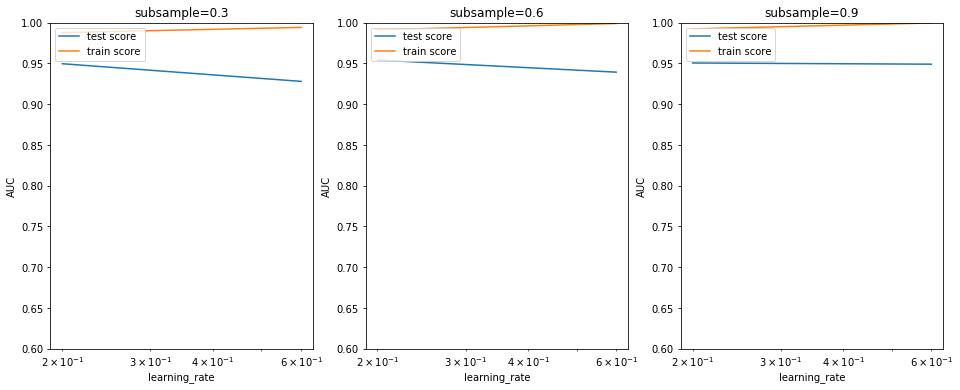

In [58]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [59]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [60]:
# predict
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9987620e-01, 1.2377757e-04],
       [9.9980235e-01, 1.9764129e-04],
       [9.9981219e-01, 1.8779545e-04],
       [9.9935341e-01, 6.4659910e-04],
       [9.9839455e-01, 1.6054598e-03],
       [9.9982888e-01, 1.7113073e-04],
       [9.9954700e-01, 4.5297624e-04],
       [9.9944913e-01, 5.5086729e-04],
       [9.9976951e-01, 2.3048650e-04],
       [9.9696469e-01, 3.0353032e-03]], dtype=float32)

In [61]:
# roc_auc
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.9484868732425735

In [62]:
# feature importance
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'app': 0.27878824,
 'channel': 0.21394157,
 'day_of_week': 0.02267693,
 'day_of_year': 0.0,
 'device': 0.17192616,
 'hour': 0.03604142,
 'ip': 0.04729222,
 'ip_count': 0.121292084,
 'ip_day_hour': 0.0,
 'ip_hour_app': 0.0,
 'ip_hour_channel': 0.0,
 'ip_hour_device': 0.0,
 'ip_hour_os': 0.008167093,
 'month': 0.0,
 'os': 0.09987429}

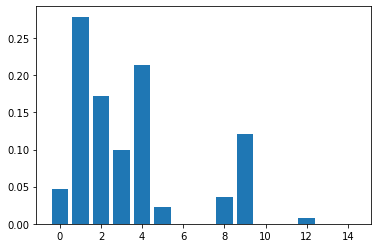

In [63]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()